In [ ]:
# This notebook is a modification of a notebook provided by the ART Toolbox: https://github.com/Trusted-AI/adversarial-robustness-toolbox

# Poisoning using Clean Label Backdoor Attacks in ART

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv1D, Flatten, Permute
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, load_cifar10, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD

In [2]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_fmodel(input_dim, hidden_dim, num_layers, num_classes):
    model = Sequential()
    model.add(Dense(units=hidden_dim, activation='relu', input_shape=(input_dim,)))
    for i in range(num_layers-1):
        model.add(Dense(units=hidden_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
    return model

In [15]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_cifar10(raw=True)

In [16]:
x_raw.shape

(50000, 32, 32, 3)

In [3]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

In [4]:
# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

### Choose backdoor pattern and backdoor target labels for training

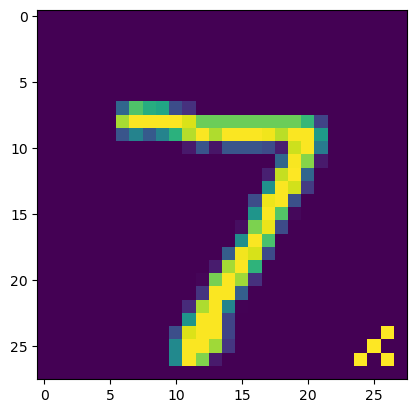

In [5]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)
plt.imshow(pdata[0].squeeze())

pdata = pdata.reshape(pdata.shape[0], -1)

# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

## On the default architecture

In [6]:
proxy_model = KerasClassifier(create_model())
proxy = AdversarialTrainerMadryPGD(proxy_model, nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train, nb_epochs=10)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

2024-05-17 11:47:01.846668: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-05-17 11:47:01.889559: W tensorflow/c/c_api.cc:304] Operation '{name:'count/Assign' id:131 op device:{requested: '', assigned: ''} def:{{{node count/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count, count/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-17 11:47:02.995110: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/Softmax' id:121 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigg

In [7]:
clean_preds = np.argmax(proxy_model.predict(x_test), axis=1)
clean_acc = np.sum(clean_preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))


Clean test set accuracy: 98.30%


In [8]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
# pdata, plabels = attack.poison(x_train.reshape(x_train.shape[0], -1), y_train)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

954 (10000, 28, 28, 1)
954
954
Label: 9


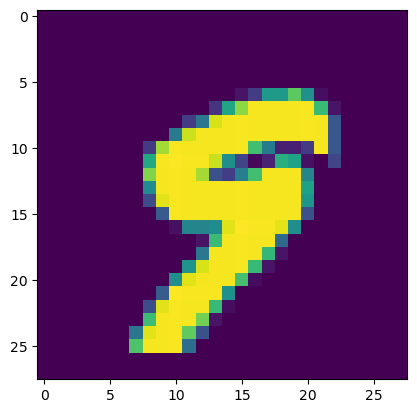

In [9]:
cnt = x_train[np.all(y_train == targets, axis=1)]
print(len(cnt), pdata.shape)

a1 = np.all(y_train == targets, axis=1)
a2 = np.all(plabels == targets, axis=1)
print(np.sum([a1[i] or a2[i] for i in range(len(a1))]))

poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
idx = 0
plt.imshow(poisoned[idx].reshape(28, 28).squeeze())
print(f"Label: {np.argmax(poisoned_labels[idx])}")

In [10]:
# tf.disable_v2_behavior()

model = KerasClassifier(create_model())
model.fit(pdata, plabels, nb_epochs=10)

2024-05-17 12:02:58.394654: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/Adam/dense_2/bias/v/Assign' id:1043 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_2/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_2/bias/v, training_2/Adam/dense_2/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [11]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
poison_preds = np.argmax(model.predict(px_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
print(poison_preds.shape)
poison_total = poison_preds.shape[0]

poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))

2024-05-17 12:05:10.514725: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_3/Softmax' id:690 op device:{requested: '', assigned: ''} def:{{{node dense_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Clean test set accuracy: 98.18%
(8991,)

Poison test set accuracy: 0.10%


## On my architecture

In [33]:
input_dim, hidden_dim, num_layers, num_classes = x_train.shape[1]**2, 100, 3, 10

In [34]:
proxy = KerasClassifier(create_fmodel(input_dim, hidden_dim, num_layers, num_classes))
# proxy = AdversarialTrainerMadryPGD(proxy_model, nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train.reshape(x_train.shape[0], -1), y_train)

2024-05-17 11:10:55.131143: W tensorflow/c/c_api.cc:304] Operation '{name:'total_6/Assign' id:3323 op device:{requested: '', assigned: ''} def:{{{node total_6/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_6, total_6/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [36]:
clean_preds = np.argmax(proxy.predict(x_test.reshape(x_test.shape[0], -1)), axis=1)
clean_acc = np.sum(clean_preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

2024-05-17 11:11:07.446511: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_21/Softmax' id:3318 op device:{requested: '', assigned: ''} def:{{{node dense_21/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_21/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Clean test set accuracy: 95.44%


In [96]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy,
                                           target=targets, pp_poison=percent_poison, norm=2, eps=10,
                                           eps_step=1, max_iter=1000)
# pdata, plabels = attack.poison(x_train.reshape(x_train.shape[0], -1), y_train)
pdata, plabels = attack.poison(x_train.reshape(x_train.shape[0], -1), y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

978 (10000, 784)
978
978
Label: 9


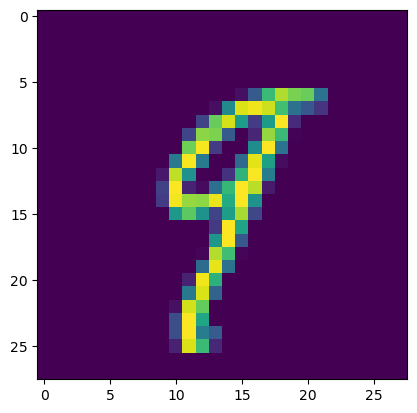

In [102]:
cnt = x_train[np.all(y_train == targets, axis=1)]
print(len(cnt), pdata.shape)

a1 = np.all(y_train == targets, axis=1)
a2 = np.all(plabels == targets, axis=1)
print(np.sum([a1[i] or a2[i] for i in range(len(a1))]))

poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
idx = 0
plt.imshow(poisoned[idx].reshape(28, 28).squeeze())
print(f"Label: {np.argmax(poisoned_labels[idx])}")

In [83]:
model = KerasClassifier(create_fmodel(input_dim, hidden_dim, num_layers, num_classes))
model.fit(pdata.reshape(pdata.shape[0], -1), plabels, nb_epochs=10)

2024-05-17 11:19:32.815860: W tensorflow/c/c_api.cc:304] Operation '{name:'training_34/Adam/dense_64/bias/v/Assign' id:9184 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/dense_64/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/dense_64/bias/v, training_34/Adam/dense_64/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [84]:
clean_preds = np.argmax(model.predict(x_test.reshape(x_test.shape[0], -1)), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
poison_preds = np.argmax(model.predict(px_test.reshape(px_test.shape[0], -1)), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
poison_total = poison_preds.shape[0]

poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))

2024-05-17 11:19:36.107127: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_65/Softmax' id:8873 op device:{requested: '', assigned: ''} def:{{{node dense_65/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_65/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Clean test set accuracy: 94.82%

Poison test set accuracy: 93.28%


In [12]:
import pickle

poisoned_data = {'x_train': x_train,
                'y_train': y_train,
                'px_train': pdata,
                'py_train': plabels,
                'x_test': x_test,
                'y_test': y_test,
                'px_test': px_test,
                'py_test': py_test}

with open('poisoned_data.pickle', 'wb') as file:
    pickle.dump(poisoned_data, file)